# Notebook for visualizing the results of a stylegan3 training


In [1]:
import os

dataset_name = f"oitaven"

experiment_number = 5
seed = 42
gpus = 2
batch = 128
CESGA = True

dataset_file = dataset_name + "_train" + (f"_{seed}" if seed is not None else "")

results_dir = f"training-runs/{dataset_file.upper()}"
experiment_name = f"000{experiment_number:0>2}-stylegan3-t-{dataset_file}-gpus{gpus}-batch{batch}-gamma0.125"

stats_filename = "stats.jsonl"
training_options_file_name = "training_options.json"
data_directory = "/mnt/netapp2/Store_uni/home/usc/ei/agl/data" if CESGA else "data"

dataset_summary_file_path = (
    f"{data_directory}/{dataset_name}/patches/processing_summary" + (f"_{seed}" if seed is not None and seed != 0 else "") + ".json"
)

stats_file_path = os.path.join(results_dir, experiment_name, stats_filename)
if not os.path.isfile(stats_file_path):
    print(f"Error: The file {stats_file_path} does not exist.")

import json

with open(dataset_summary_file_path, "r") as f:
    summary = json.load(f)

label_map = summary.get("label_map", {})
print("Label Map:", label_map)

# Labels for the classes
class_labels = [int(label) for label in label_map.keys()]
print("Class Labels:", class_labels)

Label Map: {'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}
Class Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [2]:
from visualization_utils import (
    read_jsonl,
    extract_metrics,
    extract_classification_metrics,
    summarize_training_stats,
    summarize_training_options,
    extract_confusion_matrix,
    plot_confusion_matrix,
    plot_metric,
    print_accuracies_per_class,
    compute_overall_accuracy,
    plot_accuracies,
    extract_best_tick,
    compute_adversarial_starting_tick,
    class_colors,
)

In [3]:
adversarial_starting_tick = compute_adversarial_starting_tick(
    os.path.join(results_dir, experiment_name, training_options_file_name)
)
print(f"Adversarial Starting Tick: {adversarial_starting_tick}")

Adversarial Starting Tick: 65


In [4]:
summarize_training_options(os.path.join(results_dir, experiment_name, training_options_file_name))

📋 Training Configuration Summary
────────────────────────────────────
⚖️ Class weight: 0.1
🖥️ Number of GPUs: 2
📦 Batch size: 128
🎯 Uniform class labels: False
🧪 Discriminator on generated images: True
🖼️ Autoencoder kimg: 648
🎛️  ADA target present ✅ → Value: 0.6


In [5]:
jsonl_data = read_jsonl(stats_file_path)
metrics = extract_metrics(jsonl_data, class_labels=class_labels)
summarize_training_stats(metrics, exclude_first_tick=True)

🕒 Total time: 2h 49min 50s
📊 Total kimg: 1296.0
📈 Total ticks: 129
⏱️ Mean time per tick: 1min 13s (std: 13s)
⏳ Mean time per kimg: 7s (std: 1s)


In [6]:
print("────────────────────────────────────")
print("Using average accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=False, network_snapshot_ticks=None
)

────────────────────────────────────
Using average accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 107
🖼️  kimg: 1082.112
📈 Avg Accuracy (Train): 0.9827 ± 0.0156
📊 Avg Accuracy (Val):   0.8503 ± 0.1491
🏁 Overall Accuracy (Train): 0.9832
✅ Overall Accuracy (Val):   0.9072


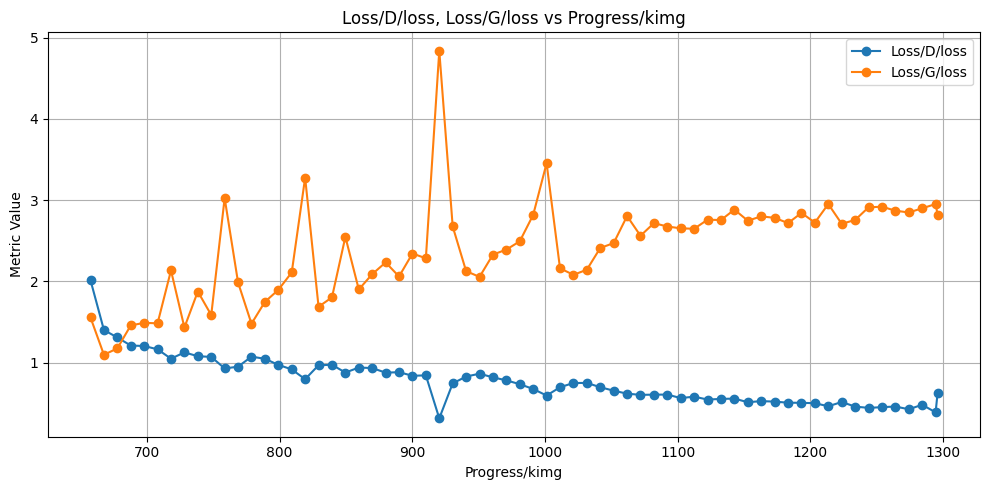

In [7]:
plot_metric(
    metrics, metrics=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg", start_tick=adversarial_starting_tick
)

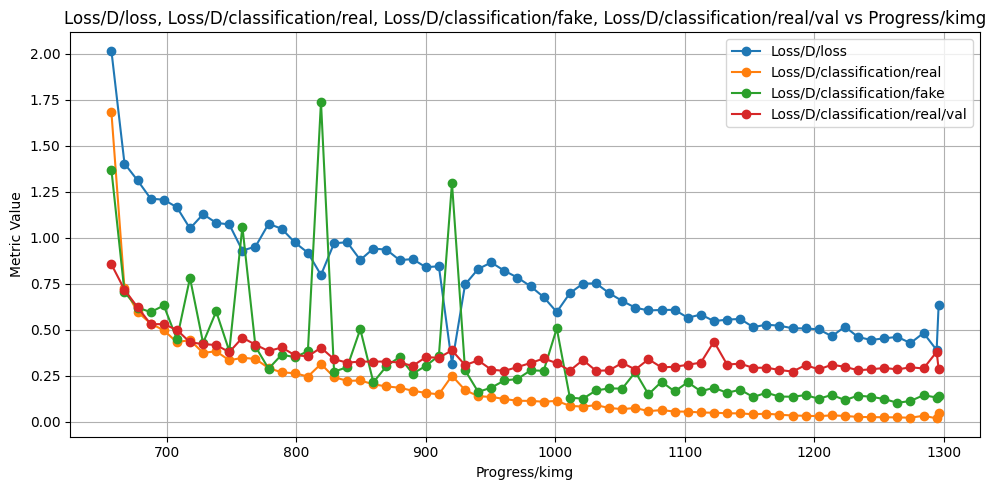

In [8]:
plot_metric(
    data=metrics,
    metrics=[
        "Loss/D/loss",
        "Loss/D/classification/real",
        "Loss/D/classification/fake",
        "Loss/D/classification/real/val",
    ],
    x_axis="Progress/kimg",
    start_tick=adversarial_starting_tick,
)

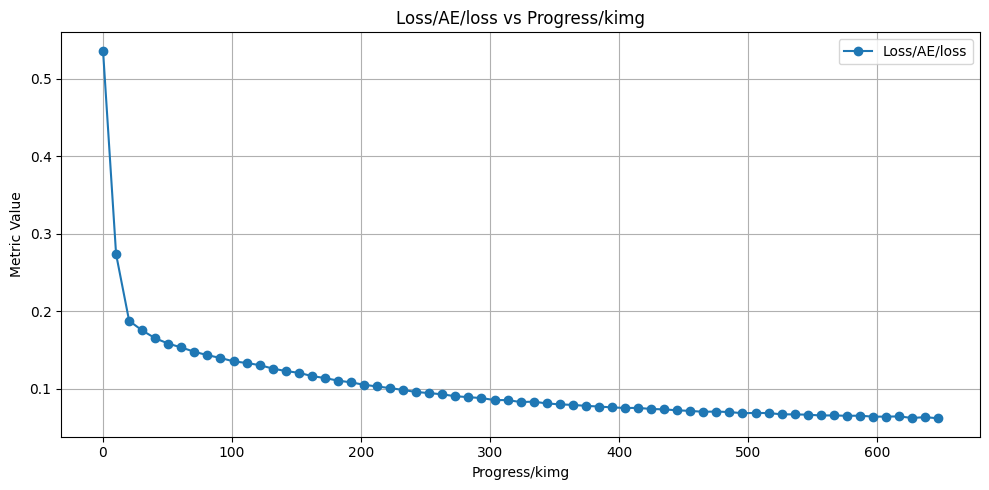

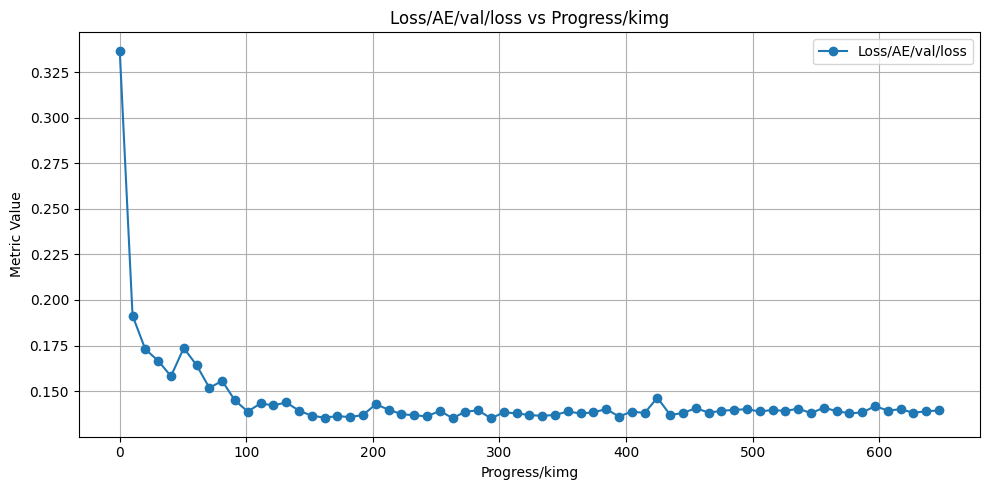

In [9]:
if "Loss/AE/loss" in metrics and any(metrics["Loss/AE/loss"]):
    plot_metric(metrics, metrics=["Loss/AE/loss"], x_axis="Progress/kimg", end_tick=adversarial_starting_tick - 1) # do not include first adversarial tick
    plot_metric(metrics, metrics=["Loss/AE/val/loss"], x_axis="Progress/kimg", end_tick=adversarial_starting_tick - 1) # do not include first adversarial tick

In [10]:
def calculate_pair_differences(metrics, metric_name):
    diffs = []
    values = metrics.get(metric_name, [])
    for i in range(1, len(values), 2):
        diffs.append(values[i] - values[i - 1])
    return diffs

In [11]:
pair_differences = calculate_pair_differences(metrics, "Loss/AE/loss")
print(" ".join([f"{diff:.3f}" for diff in pair_differences]))

-0.263 -0.012 -0.007 -0.006 -0.004 -0.002 -0.004 -0.002 -0.003 -0.002 -0.002 -0.002 -0.001 -0.002 -0.001 -0.000 0.001 -0.001 -0.001 -0.001 0.000 -0.001 -0.001 0.000 -0.001 -0.000 -0.000 -0.001 -0.000 -0.001 0.000 0.001 0.002 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000


In [12]:
pair_differences = calculate_pair_differences(metrics, "Loss/AE/val/loss")
print(" ".join([f"{diff:.3f}" for diff in pair_differences]))

-0.145 -0.006 0.015 -0.012 -0.011 0.004 0.002 -0.003 0.001 0.001 -0.003 -0.001 0.003 0.004 -0.004 -0.001 -0.000 0.002 0.001 -0.004 -0.001 -0.009 0.003 0.001 0.000 0.001 0.001 0.003 -0.001 0.003 0.001 0.001 0.110 0.131 0.016 -0.134 0.001 -0.222 0.008 0.026 -0.152 -0.025 0.014 0.028 0.015 -0.670 0.013 0.032 0.083 -0.031 0.021 0.024 -0.022 0.013 0.029 0.003 0.056 -0.015 0.014 0.034 0.029 -0.053 0.047 0.002 -0.010


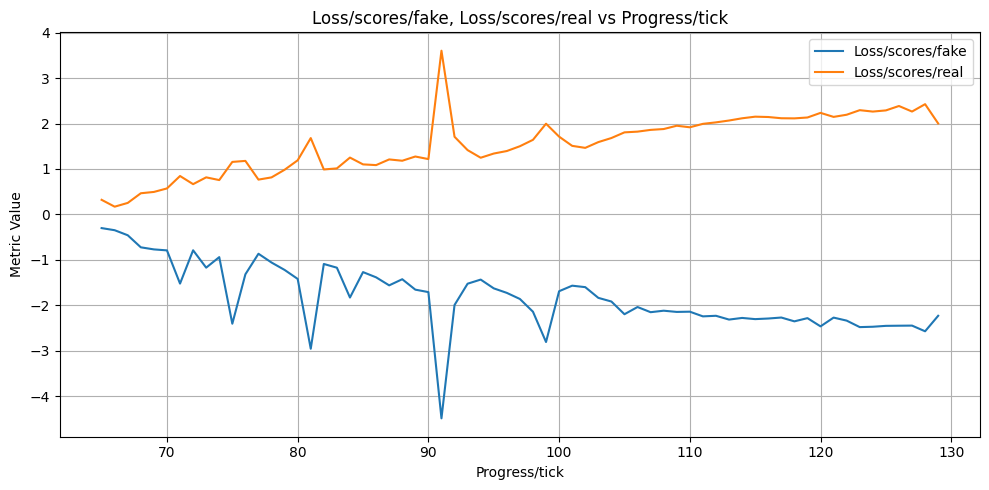

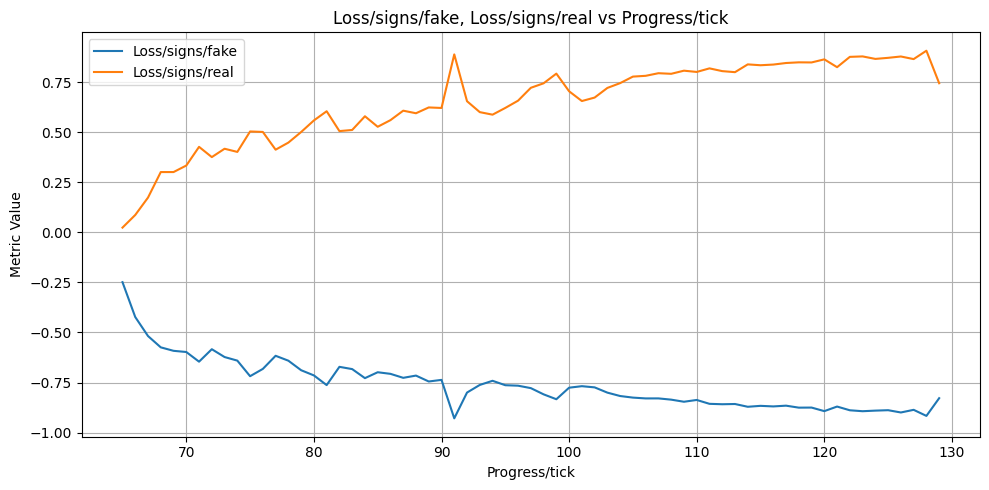

In [13]:
plot_metric(
    metrics,
    metrics=["Loss/scores/fake", "Loss/scores/real"],
    x_axis="Progress/tick",
    marker=None,
    start_tick=adversarial_starting_tick,
)
plot_metric(
    metrics,
    metrics=["Loss/signs/fake", "Loss/signs/real"],
    x_axis="Progress/tick",
    marker=None,
    start_tick=adversarial_starting_tick,
)

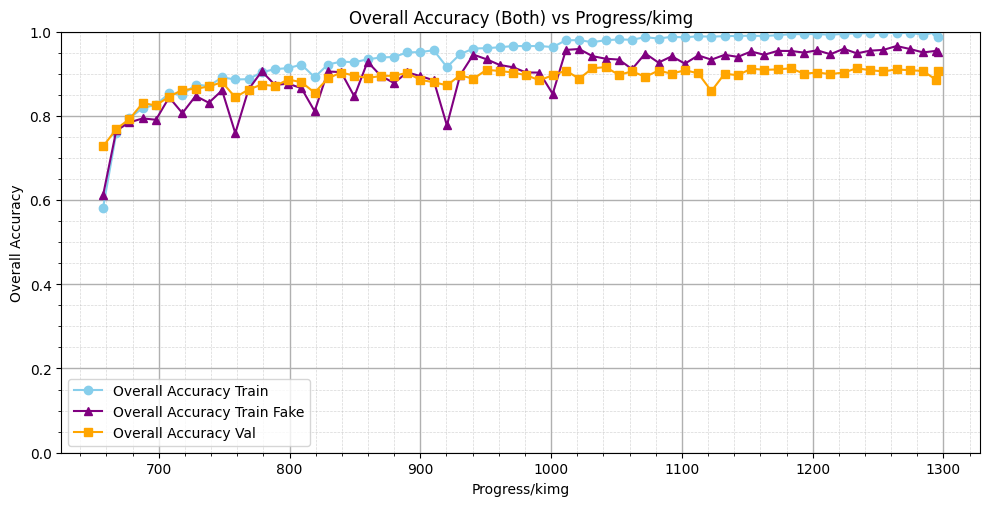

In [14]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
metrics["overall_accuracy_train"], metrics["overall_accuracy_val"], metrics["overall_accuracy_train_fake"] = (
    compute_overall_accuracy(classification_metrics)
)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=False,
    plot_type="overall",
    dataset="both",
    include_fake=True,
    start_tick=adversarial_starting_tick,
)

Last 10 accuracies per class (val):
Class 0: ['0.913', '0.891', '0.957', '0.913', '0.957', '0.935', '0.935', '0.935', '0.891', '0.826']
Class 1: ['0.720', '0.640', '0.760', '0.680', '0.680', '0.680', '0.640', '0.640', '0.560', '0.720']
Class 2: ['0.778', '0.889', '0.833', '0.833', '0.833', '0.833', '0.889', '0.889', '0.833', '0.778']
Class 3: ['0.429', '0.429', '0.429', '0.429', '0.429', '0.429', '0.429', '0.429', '0.429', '0.429']
Class 4: ['0.739', '0.783', '0.652', '0.696', '0.652', '0.739', '0.696', '0.739', '0.783', '0.739']
Class 5: ['0.800', '0.800', '0.800', '0.800', '0.800', '0.800', '0.800', '0.800', '0.733', '0.600']
Class 6: ['0.936', '0.919', '0.922', '0.925', '0.942', '0.919', '0.936', '0.907', '0.919', '0.948']
Class 7: ['0.911', '0.945', '0.950', '0.939', '0.916', '0.937', '0.945', '0.942', '0.963', '0.929']
Class 8: ['1.000', '1.000', '0.958', '0.938', '0.938', '0.958', '0.938', '0.979', '0.958', '0.979']
Class 9: ['0.856', '0.840', '0.884', '0.895', '0.890', '0.906', 

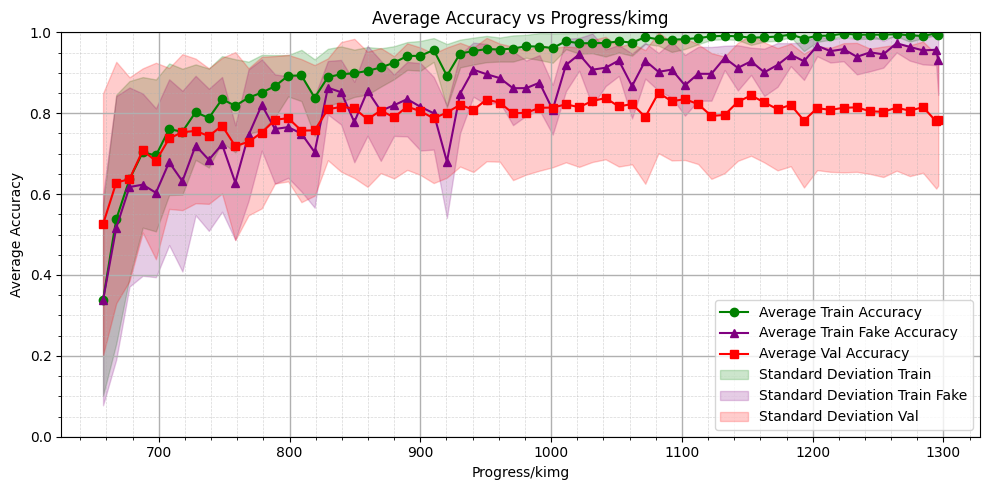

In [15]:
print_accuracies_per_class(metrics, class_labels, last_ticks=10, data_type="val")
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="average",
    dataset="both",
    include_fake=True,
    start_tick=adversarial_starting_tick,
)

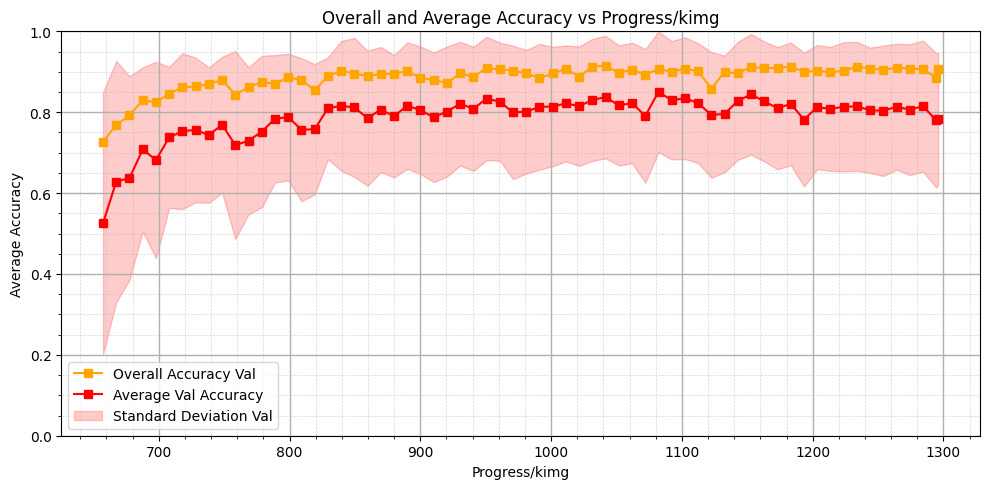

In [16]:
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="both",
    dataset="val",
    start_tick=adversarial_starting_tick,
)

In [17]:
class_names_map = [
    "Auga",
    "Terra",
    "Pedras",
    "Asfalto",
    "Formigón",
    "Tellados",
    "Prados",
    "Árbores Nativas",
    "Piñeiros",
    "Eucaliptos",
]

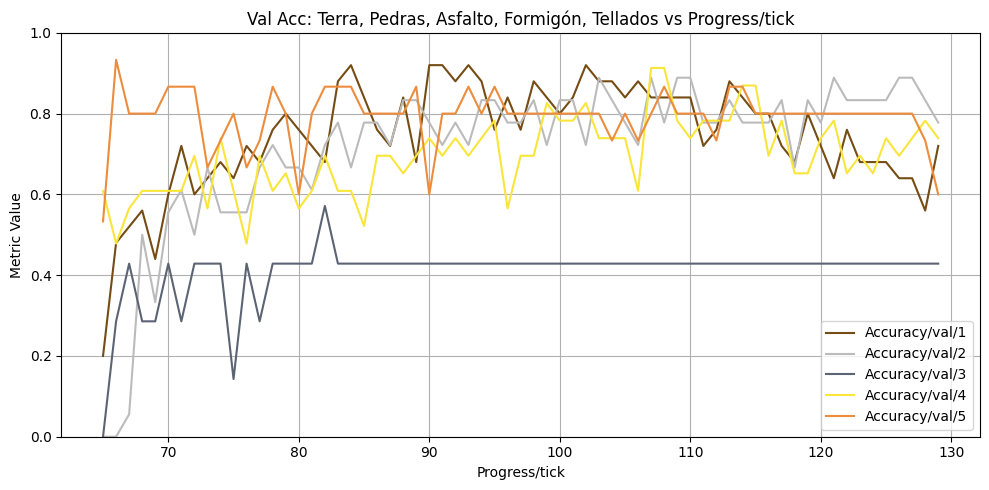

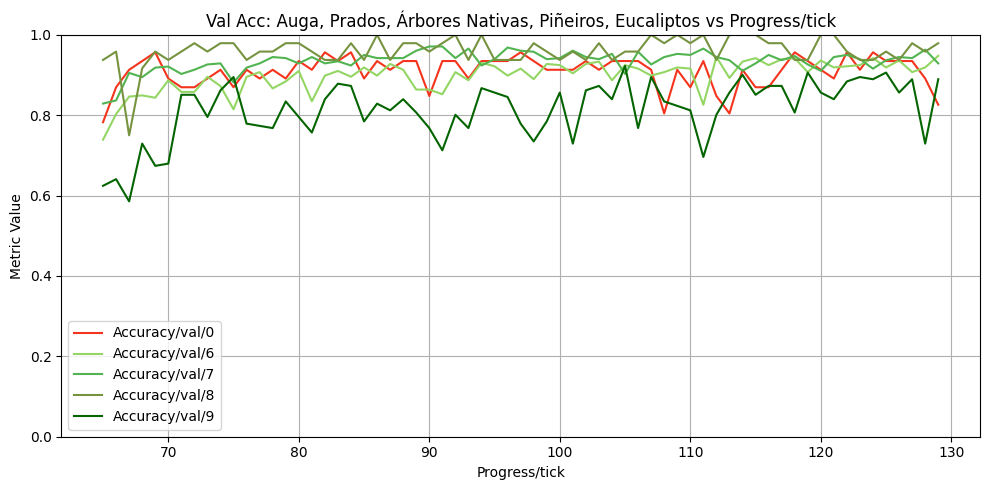

In [18]:
minority_class_labels = [1, 2, 3, 4, 5]
colors = [class_colors[c] for c in minority_class_labels]
plot_metric(
    metrics,
    metrics=[f"Accuracy/val/{c}" for c in minority_class_labels],
    x_axis="Progress/tick",
    marker=None,
    ylim=(0, 1),
    colors=colors,
    title="Val Acc: "
    + ", ".join(
        class_name for i, class_name in enumerate(class_names_map) if i in minority_class_labels and i in class_labels
    )
    + " vs Progress/tick",
    start_tick=adversarial_starting_tick,
)
mayority_class_labels = [0, 6, 7, 8, 9]
colors = [class_colors[c] for c in mayority_class_labels]
plot_metric(
    metrics,
    metrics=[f"Accuracy/val/{c}" for c in mayority_class_labels],
    x_axis="Progress/tick",
    marker=None,
    ylim=(0, 1),
    colors=colors,
    title="Val Acc: "
    + ", ".join(
        class_name for i, class_name in enumerate(class_names_map) if i in mayority_class_labels and i in class_labels
    )
    + " vs Progress/tick",
    start_tick=adversarial_starting_tick,
)

Tick: 129/129
kimg used for training: 1296.000/1296.000


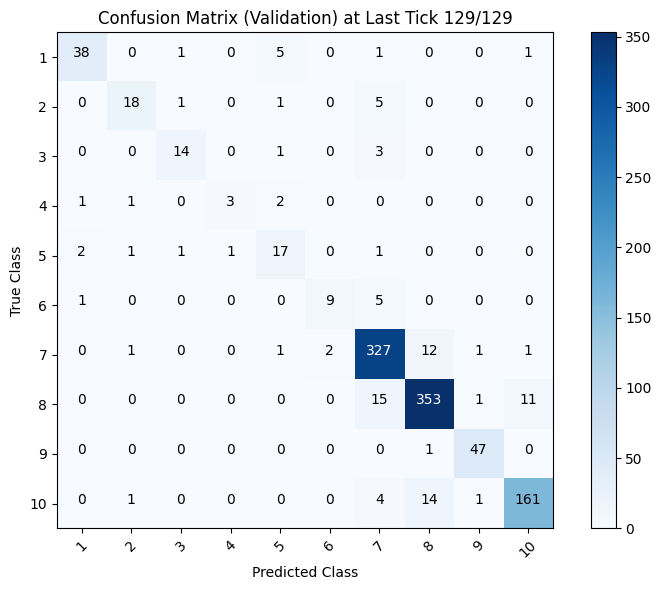

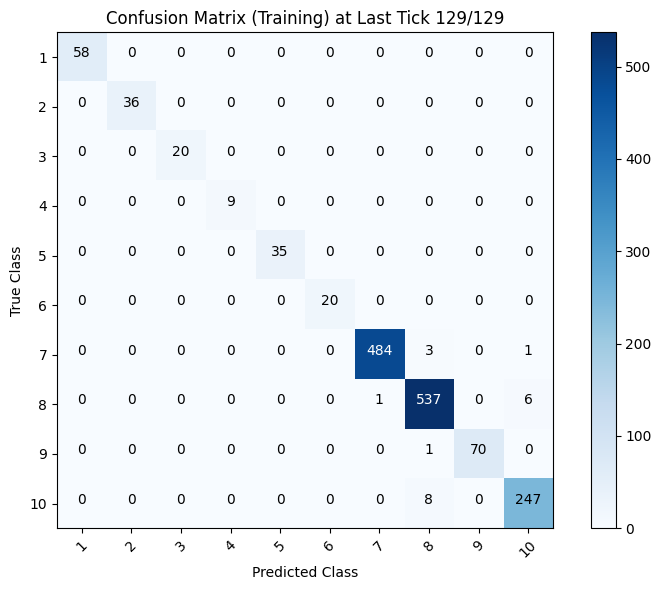

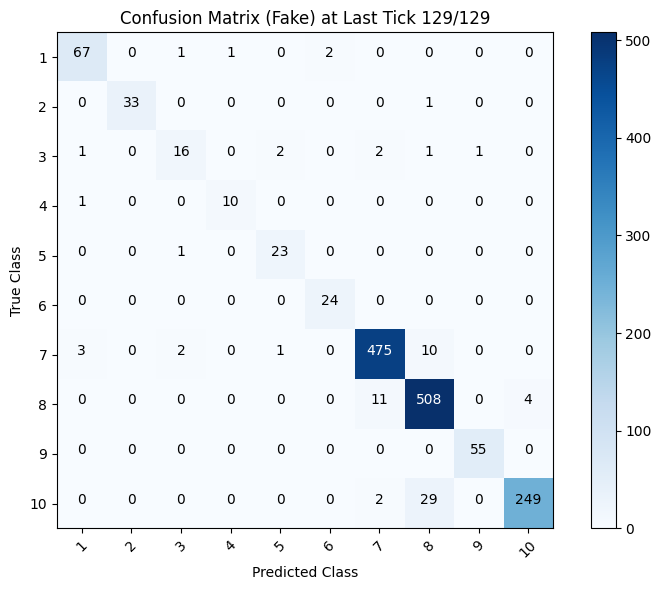

In [19]:
total_tick = int(metrics["Progress/tick"][-1])
total_kimg = float(metrics["Progress/kimg"][-1])

print(f"Tick: {total_tick}/{total_tick}")
print(f"kimg used for training: {total_kimg:.3f}/{total_kimg:.3f}")

# ------------- Validation ------------- #
confusion_matrix = extract_confusion_matrix(jsonl_data, class_labels=class_labels, data_type="val")
plot_confusion_matrix(
    confusion_matrix,
    class_labels=class_labels,
    title=f"Confusion Matrix (Validation) at Last Tick {total_tick}/{total_tick}",
)

# ------------- Training (real) ------------- #
confusion_matrix = extract_confusion_matrix(jsonl_data, class_labels=class_labels, data_type="real")
plot_confusion_matrix(
    confusion_matrix,
    class_labels=class_labels,
    title=f"Confusion Matrix (Training) at Last Tick {total_tick}/{total_tick}",
)

# ------------- Training (fake) ------------- #
confusion_matrix = extract_confusion_matrix(jsonl_data, class_labels=class_labels, data_type="fake")
plot_confusion_matrix(
    confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Fake) at Last Tick {total_tick}/{total_tick}"
)